In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import re

In [ ]:
df = pd.read_csv('./drive/MyDrive/Colab Notebooks/Data/train.csv')

In [ ]:
df =  df.sample(n=45000,random_state=1)

In [ ]:
df.head()

,question,sql
1661,What are all the 300 m group (mm) with a .308 ...,SELECT 300 m group (mm) FROM table WHERE .308 ...
7017,What are the alternative names of those satell...,SELECT Alt. Name FROM table WHERE Notes = Miss...
29628,Player than won in 2003?,SELECT Player FROM table WHERE Year(s) won = 2003
38300,What venue features an away side score of 11.1...,SELECT Venue FROM table WHERE Away team score ...
11053,Name the most races for flaps larger than 2.0,SELECT MAX Races FROM table WHERE FLaps > 2.0


In [ ]:
def data_cleaning(data,col_1):
    data[col_1]=data[col_1].apply(lambda x:x.lower())
    # Remove extra spaces
    data[col_1] = data[col_1].apply(lambda x: x.strip())
    return data[col_1]
# Add start and end tokens to target sequences

In [ ]:
df['question'] = data_cleaning(df,'question')

In [ ]:
df['sql'] = df['sql'].apply(lambda x : 'START_ '+ str(x) + ' _END')

In [ ]:
data = pd.DataFrame()
data['input_data'] = df['question']
data['sql'] = df['sql']
df = data
df.head()

,input_data,sql
1661,what are all the 300 m group (mm) with a .308 ...,START_ SELECT 300 m group (mm) FROM table WHER...
7017,what are the alternative names of those satell...,START_ SELECT Alt. Name FROM table WHERE Notes...
29628,player than won in 2003?,START_ SELECT Player FROM table WHERE Year(s) ...
38300,what venue features an away side score of 11.1...,START_ SELECT Venue FROM table WHERE Away team...
11053,name the most races for flaps larger than 2.0,START_ SELECT MAX Races FROM table WHERE FLaps...


In [ ]:
df['input_sent_length'] = df['input_data'].apply(lambda x:len(x.split()))
df['sql_sent_length'] = df['sql'].apply(lambda x:len(x.split()))
df.head()

,input_data,sql,input_sent_length,sql_sent_length
1661,what are all the 300 m group (mm) with a .308 ...,START_ SELECT 300 m group (mm) FROM table WHER...,22,22
7017,what are the alternative names of those satell...,START_ SELECT Alt. Name FROM table WHERE Notes...,19,17
29628,player than won in 2003?,START_ SELECT Player FROM table WHERE Year(s) ...,5,11
38300,what venue features an away side score of 11.1...,START_ SELECT Venue FROM table WHERE Away team...,10,13
11053,name the most races for flaps larger than 2.0,START_ SELECT MAX Races FROM table WHERE FLaps...,9,11


In [ ]:
df.describe()

,input_sent_length,sql_sent_length
count,40000.000000,40000.000000
mean,11.638150,13.648075
std,4.498213,3.400495
min,3.000000,6.000000
25%,8.000000,11.000000
50%,11.000000,13.000000
75%,14.000000,15.000000
max,44.000000,84.000000


In [ ]:
max(df['input_sent_length'])

44

In [ ]:
max_input_sen_length = max(df['input_sent_length'])
max_output_sen_length = max(df['sql_sent_length'])

In [ ]:
from keras.preprocessing.text import one_hot
from keras.backend import clear_session
import string
import numpy as np
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import LSTM, Input, TimeDistributed, Dense, Activation, RepeatVector, Embedding,Bidirectional
from keras.losses import sparse_categorical_crossentropy
import pickle

In [ ]:
def token(sentances):
  # create tokenization
  text_token =(filters='$')
  text_token.fiTokenizert_on_texts(sentances)
  return text_token.texts_to_sequences(sentances),text_token

In [ ]:
def save_artifact(artifact,fname):
    # Open a file and use dump()
    with open(fname, 'wb') as file:

        # A new file will be created
        pickle.dump(artifact, file)

In [ ]:
df_arr = np.array(df)

In [ ]:
input_text_tokenized,input_text_tokenizer = token(df_arr[:,0])
output_text_tokenized,output_text_tokenizer = token(df_arr[:,1])

In [ ]:
save_artifact(input_text_tokenizer,'input_text_tokenizer.pkl')
save_artifact(output_text_tokenizer,'output_text_tokenizer.pkl')

In [ ]:
print('Maximum length english sentence: {}'.format(len(max(input_text_tokenized,key=len))))
print('Maximum length sql sentence: {}'.format(len(max(output_text_tokenized,key=len))))

Maximum length english sentence: 44
Maximum length sql sentence: 84


In [ ]:
# Check language length
input_vocab = len(input_text_tokenizer.word_index) + 1
output_vocab = len(output_text_tokenizer.word_index) + 1
print("input_vocab vocabulary is of {} unique words".format(input_vocab))
print("output_vocab vocabulary is of {} unique words".format(output_vocab))

input_vocab vocabulary is of 42969 unique words
output_vocab vocabulary is of 33311 unique words


In [ ]:
max_input_len = int(len(max(input_text_tokenized,key=len)))
max_output_len = int(len(max(output_text_tokenized,key=len)))

input_pad_sentence = pad_sequences(input_text_tokenized, max_input_len, padding = "post")
output_pad_sentence = pad_sequences(output_text_tokenized, max_output_len, padding = "post")
pad_sequences
# Reshape data
input_pad_sentence = input_pad_sentence.reshape(*input_pad_sentence.shape, 1)
output_pad_sentence = output_pad_sentence.reshape(*output_pad_sentence.shape, 1)

In [ ]:
temp =[]
for i in output_pad_sentence[1:]:
    temp.append(i)

In [ ]:
output_pad_sentence_2 = np.array(temp)

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(input_pad_sentence,output_pad_sentence,test_size=0.05,random_state=2)

In [ ]:
callback = [tf.keras.callbacks.EarlyStopping(patience=3),
            tf.keras.callbacks.ReduceLROnPlateau(patience=3)]

In [ ]:
# Checkpoint callback tanımı
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_filepath = './drive/MyDrive/Colab Notebooks/best_model.keras'
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      mode='min',
                                      verbose=1)

In [ ]:

clear_session()

input_sequence = Input(shape=(max_input_len,))

embedding = Embedding(input_dim=input_vocab, output_dim=128,)(input_sequence)

encoder = Bidirectional(LSTM(100, return_sequences=False,dropout=0.2))(embedding)

r_vec = RepeatVector(max_output_len)(encoder)

decoder = Bidirectional(LSTM(100, return_sequences=True, dropout=0.2))(r_vec)

logits = TimeDistributed(Dense(output_vocab))(decoder)

enc_dec_model = Model(input_sequence, Activation('softmax')(logits))

enc_dec_model.compile(loss=sparse_categorical_crossentropy,
                      optimizer=tf.keras.optimizers.Adam(1e-3),
                      metrics=['accuracy'])

enc_dec_model.summary()

ep = 25
batch_size=164

model_results = enc_dec_model.fit(x_train, y_train,
                                  batch_size=batch_size,
                                  epochs=ep,
                                  validation_data=(x_test, y_test),
                                  callbacks=[checkpoint_callback])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 44)]              0         
                                                                 
 embedding (Embedding)       (None, 44, 128)           5500032   
                                                                 
 bidirectional (Bidirection  (None, 200)               183200    
 al)                                                             
                                                                 
 repeat_vector (RepeatVecto  (None, 84, 200)           0         
 r)                                                              
                                                                 
 bidirectional_1 (Bidirecti  (None, 84, 200)           240800    
 onal)                                                           
                                                             

In [ ]:

from tensorflow.keras.models import load_model

model_path = './drive/MyDrive/Colab Notebooks/best_model.keras'
loaded_model = load_model(model_path)
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 44)]              0         
                                                                 
 embedding (Embedding)       (None, 44, 128)           5500032   
                                                                 
 bidirectional (Bidirection  (None, 200)               183200    
 al)                                                             
                                                                 
 repeat_vector (RepeatVecto  (None, 84, 200)           0         
 r)                                                              
                                                                 
 bidirectional_1 (Bidirecti  (None, 84, 200)           240800    
 onal)                                                           
                                                             

In [ ]:
input_sentences = df_arr[:,0]
output_sentences = df_arr[:,1]
def logits_to_sentence(logits, tokenizer):

    index_to_words = {idx: word for word, idx in tokenizer.word_index.items()}
    index_to_words[0] = '<empty>'
    sen = ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])
    sen = sen.replace('<empty>','')
    sen = sen.replace('start','')
    sen = sen.replace('end','')
    return sen

In [ ]:
input_pad_sentence = pad_sequences(input_text_tokenized, max_input_len, padding = "post")
output_pad_sentence = pad_sequences(output_text_tokenized, max_output_len, padding = "post")

In [ ]:
max_input_len,max_output_len

(44, 84)

In [ ]:
def convertQuest2Qry(question):
    question = [question]
    model_input = pad_sequences(input_text_tokenizer.texts_to_sequences(question),44,padding='post')
    qry = logits_to_sentence(loaded_model.predict(model_input)[0],output_text_tokenizer)
    return qry

In [ ]:
convertQuest2Qry("Name the most races for flaps larger than 2.0 ")

1/1 [==============================] - 3s 3s/step


'_ select min wins from table where rank = 0 _                                                                         '

In [ ]:
model_input = pad_sequences(input_text_tokenizer.texts_to_sequences(["sql"]),44,padding='post')

In [ ]:
logits_to_sentence(loaded_model.predict(model_input)[0],output_text_tokenizer)

1/1 [==============================] - 0s 20ms/step


'_ select location from table where year = = _                                                                          '

In [ ]:
for i in [81,47,75,4781,4775]:
    print("The Input sentence is: {}".format(input_sentences[i]))
    print("The SQL Query is: {}".format(output_sentences[i]))
    print('The predicted SQL Query is :')
    print(logits_to_sentence(enc_dec_model.predict(input_pad_sentence[i:i+1])[0], output_text_tokenizer))
    print('--'*20)

The Input sentence is: what is the style of the dance choreographed by nacho pop with result of safe?
The SQL Query is: START_ SELECT Style FROM table WHERE Results = safe AND Choreographer = nacho pop _END
The predicted SQL Query is :
1/1 [==============================] - 1s 1s/step
_ select engine from table where year = and and name = = _ _                                                                     
----------------------------------------
The Input sentence is: what is the start address when the network number bit field is 16?
The SQL Query is: START_ SELECT Start address FROM table WHERE Size of network number bit field = 16 _END
The predicted SQL Query is :
1/1 [==============================] - 0s 24ms/step
_ select count rank from table where where = = and and = = < _                                                                    
----------------------------------------
The Input sentence is: what's the overall rank with viewers (m) of 7.44
The SQL Query is: STAR

In [ ]:
enc_dec_model.save('best_wikisql_model.keras')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: >

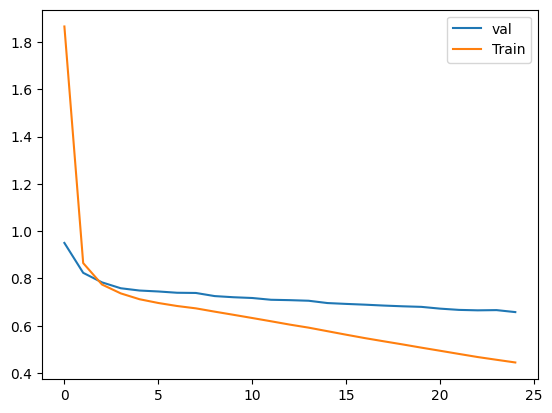

In [ ]:
# 'val_loss' ve 'loss' uzunluklarını kontrol edelim
val_loss_len = len(model_results.history['val_loss'])
loss_len = len(model_results.history['loss'])

# En kısa uzunluğu bulalım
min_len = min(val_loss_len, loss_len)

# 'val_loss' ve 'loss' değerlerini kısaltalım
val_loss = model_results.history['val_loss'][:min_len]
loss = model_results.history['loss'][:min_len]

# x eksenini yeniden ayarlayalım
x_values = range(min_len)

# Çizim yapalım
sns.lineplot(x=x_values, y=val_loss, label='val')
sns.lineplot(x=x_values, y=loss, label='Train')

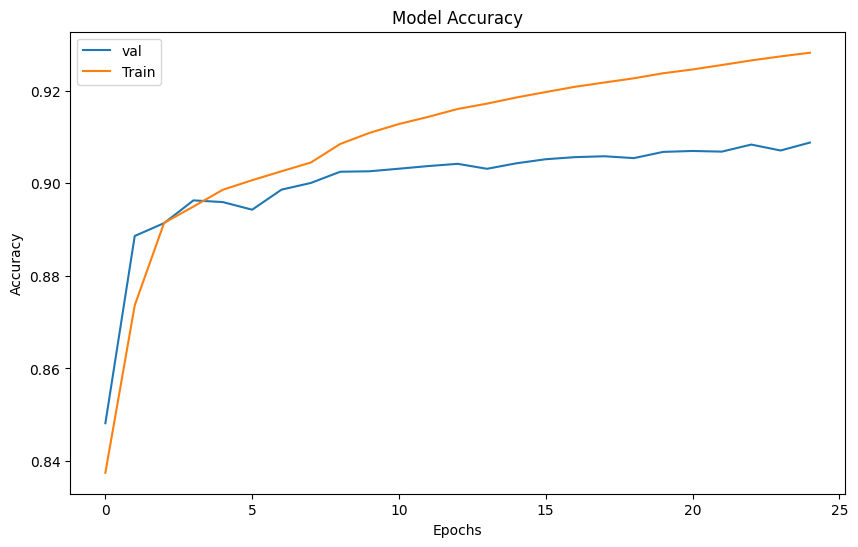

In [ ]:
# val_accuracy ve accuracy listelerinin uzunluklarını kontrol edelim
val_accuracy_len = len(model_results.history['val_accuracy'])
accuracy_len = len(model_results.history['accuracy'])

# En kısa uzunluğu bulalım
min_len = min(val_accuracy_len, accuracy_len)

# val_accuracy ve accuracy değerlerini kısaltalım
val_accuracy = model_results.history['val_accuracy'][:min_len]
accuracy = model_results.history['accuracy'][:min_len]

# x eksenini yeniden ayarlayalım
x_values = range(min_len)

# Çizim yapalım
plt.figure(figsize=(10, 6))
sns.lineplot(x=x_values, y=val_accuracy, label='val')
sns.lineplot(x=x_values, y=accuracy, label='Train')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()